In [6]:
import torch
import torch.nn as nn
from torch import Tensor
from lampe.nn import ResMLP
from zuko.flows import MAF, NAF, NSF, CNF
from pathlib import Path
import os
from lampe.inference import NPE
from lampe.data import H5Dataset
from tqdm import tqdm
from DataProcuring import Data
import numpy as np
from lampe.plots import corner
from corner_modified import *
import pandas as pd

from parameter import *
from spectra_simulator import SpectrumMaker
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal

scratch = os.environ.get('SCRATCH', '')

In [2]:
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
])

In [3]:
from parameter import *
from spectra_simulator import SpectrumMaker, make_pt
from ProcessingSpec import ProcessSpec
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal

processing = ProcessSpec()
d = Data()

In [4]:
def simulator(theta):
    values = theta[:-4].numpy()
    values_ext = theta[-4:].numpy()
    # print(values, values_ext)
    values_actual = deNormVal(values, param_list)
    sim_res = 2e5
    dlam = 2.350/sim_res
    wavelengths = np.arange(2.320, 2.371, dlam)
    sim = SpectrumMaker(wavelengths=wavelengths, param_set=param_set, lbl_opacity_sampling=2)
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), wavelengths))
    
    values_ext_actual = deNormVal(values_ext, param_list_ext)
    # params_ext = param_set_ext.param_dict(values_ext_actual)
    
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))
    # print(np.shape(x))
    
    return x.squeeze()

In [8]:
def thetascalebackup(theta):
    return torch.Tensor(LOWER) + theta * (torch.Tensor(UPPER) - torch.Tensor(LOWER))


In [5]:
theta_sim_b = torch.Tensor([0.54, 0.59, 0.41, 0.29, 0.15, 0.08, 0.04, 0.44, 0.54, 0.79, 0.44, 0.56, 0.55, 0.42, 0.49, 0.58, 0.54, 0.82, 0.53])
theta_sim_d = torch.Tensor([0.54, 0.59, 0.41, 0.29, 0.15, 0.08, 0.04, 0.44, 0.74, 0.79, 0.44, 0.56, 0.55, 0.42, 0.49, 0.58, 0.54, 0.82, 0.53])

In [10]:
torch.Tensor(deNormVal(theta_sim_b.numpy(), param_list)), thetascalebackup(theta_sim_b)


(tensor([ 1.2000e-01,  9.8500e-01,  3.7300e+00,  1.2280e+03,  7.8000e+02,
          5.5600e+02,  4.2800e+02,  1.4400e+00,  5.7000e+00,  1.1100e+00,
         -8.4800e-01,  5.6000e+00,  9.4000e+00,  1.8690e+00, -6.1000e+00]),
 tensor([ 1.2000e-01,  9.8500e-01,  3.7300e+00,  1.2280e+03,  7.8000e+02,
          5.5600e+02,  4.2800e+02,  1.4400e+00,  5.7000e+00,  1.1100e+00,
         -8.4800e-01,  5.6000e+00,  9.4000e+00,  1.8690e+00, -6.1000e+00,
          1.4960e+00,  2.0800e+01,  4.1000e+01,  5.3000e-01]))

In [31]:
x_sim_b = simulator(theta_sim_b)
x_sim_d = simulator(theta_sim_d)

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



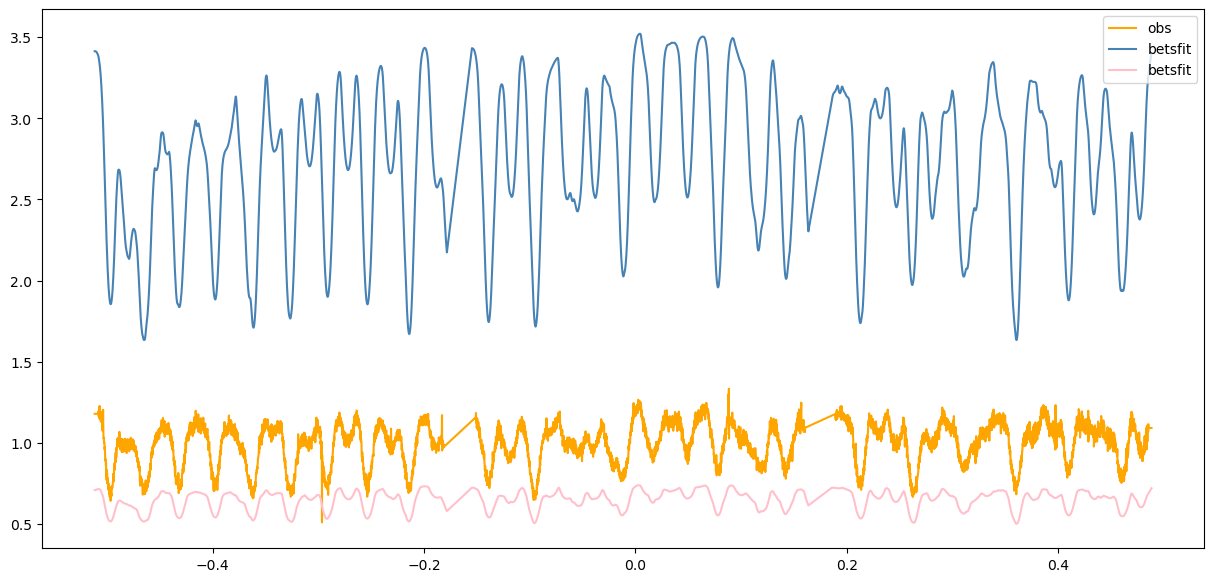

In [32]:
plt.figure(figsize=(15,7))
plt.plot(d.data_wavelengths_norm, d.flux*d.flux_scaling, color = 'orange', label = 'obs')
plt.plot(x_sim_b[1], x_sim_b[0], color = 'steelblue', label = 'betsfit')
plt.plot(x_sim_d[1], x_sim_d[0], color = 'pink', label = 'betsfit')

plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

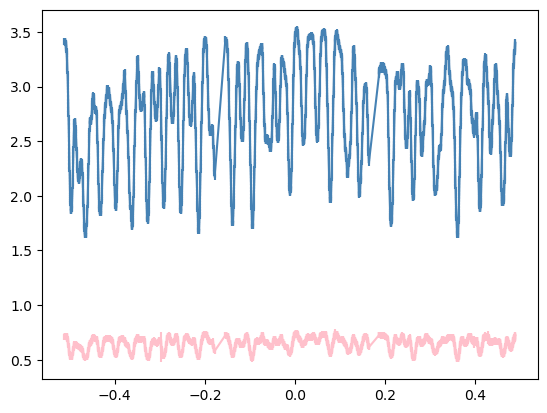

In [33]:
plt.errorbar(x_sim_b[1], x_sim_b[0], yerr =  d.err*d.flux_scaling, color = 'steelblue', label = 'betsfit')
plt.errorbar(x_sim_d[1], x_sim_d[0], yerr =  d.err*d.flux_scaling, color = 'pink', label = 'betsfit')

In [38]:
np.savetxt('x_sim_b.npy', x_sim_b)
np.savetxt('x_sim_d.npy', x_sim_d)

In [39]:
np.savetxt('theta_sim_b.npy', theta_sim_b)
np.savetxt('theta_sim_d.npy', theta_sim_d)

In [40]:
a = np.loadtxt('theta_sim_b.npy')

In [41]:
a

array([0.54000002, 0.58999997, 0.41      , 0.28999999, 0.15000001,
       0.08      , 0.04      , 0.44      , 0.54000002, 0.79000002,
       0.44      , 0.56      , 0.55000001, 0.41999999, 0.49000001,
       0.57999998, 0.54000002, 0.81999999, 0.52999997])

In [44]:
type(d.flux)

numpy.ndarray

In [45]:
np.shape(d.flux)

(6144,)

In [46]:
np.shape(x_sim_b)

(2, 6144)

In [48]:
sim_res = 2e5
dlam = 2.350/sim_res
wavelengths = np.arange(2.320, 2.371, dlam)

In [53]:
simul = SpectrumMaker(wavelengths, param_set)
pressures = simul.atmosphere.press / 1e6
val_act = deNormVal(theta_sim_b.numpy(), param_list)
params = param_set.param_dict(val_act)
temp = make_pt(params , pressures)

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [54]:
temp

array([ 427.99999714,  428.31173786,  429.87740884,  432.63685321,
        436.52991409,  441.4964346 ,  447.47625786,  454.40922699,
        462.23518512,  470.89397537,  480.32544086,  490.46942471,
        501.26577005,  512.65431999,  524.57491766,  536.96740618,
        549.77162867,  562.9279624 ,  576.38781947,  590.11299382,
        604.06568278,  618.20808368,  632.50239385,  646.91081062,
        661.39553133,  675.91840814,  690.41105436,  704.75171408,
        718.81318675,  732.46827183,  745.58976877,  758.05047704,
        769.72319608,  780.48073614,  790.31681471,  799.64561873,
        808.97267838,  818.80352385,  829.64368533,  841.99869299,
        856.37407702,  873.27536761,  893.09794048,  915.44478742,
        939.57207833,  964.7345179 ,  990.18681081, 1015.18366173,
       1038.97977536, 1060.82985636, 1080.11226919, 1098.29360707,
       1118.57907699, 1144.22688607, 1178.49524139, 1224.44659217,
       1282.64921358, 1351.95202096, 1431.16988872, 1519.11769

In [55]:
np.shape(temp)

(80,)